In [545]:
import os
import re

import shutil
import codecs, json 
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from scipy import stats
import sklearn as sk
import time
from dypac import Dypac
import nilearn
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr
import nilearn.plotting as plotting
import feature_selec_functions
import csv

import hcp_utils as hcp

# Load connectome data

In [689]:
#path to matrices
#path = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/all_features_992_Glasser.npz'
#path = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/all_features_992_Yeo17.npz'
#path = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/all_features_992_Yeo7.npz'
path = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/all_features_992_Shafer100_7N.npz'

#path to subject IDs 
path_sub = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/subID_992.txt'

#path to behavioral data (analyzed in the analyze_behavior notebook)
path_behavior = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/Behavior/HCP_behavior_includeZscores.csv'

X_features = np.load(path)['a']
subject_IDs = np.loadtxt(path_sub)
subject_IDs = subject_IDs.astype(int) #turn the subject IDS into integers
df = pd.read_csv(path_behavior)

In [690]:
X_features.shape

(992, 100, 100)

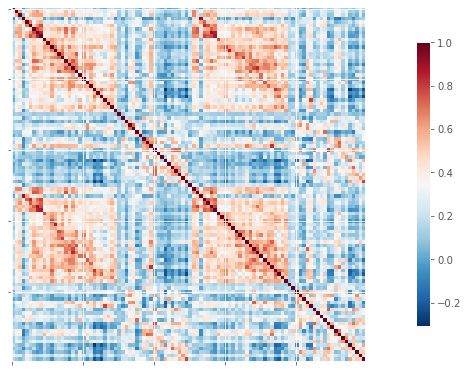

In [691]:
#Example how it looks for one subject
correlation_matrix = X_features[0]
# Mask the main diagonal for visualization:
# np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix)

# Equalize number of subjects in x_features and behavior

In [692]:
import model_preparation_functions
import importlib

importlib.reload(model_preparation_functions)

X_features, df, subject_IDs = model_preparation_functions.equalize(X_features, df, subject_IDs)

Before equalization:
Number of subjects in x_features is 992
And, the number of subjects in the behavior data is 990
So, the difference between the two data sets is 2
After equalization:
Number of subjects in x_features is 990
And, the number of subjects in the behavior data is 990
So, the difference between the two data sets is 0


In [693]:
#Set subject ID as index
df = df.set_index('Subject')
df.head(10)

Unnamed: 0 Release Acquisition Gender    Age  3T_Full_MR_Compl  \
Subject                                                                   
100206            1    S900         Q11      M  26-30              True   
100307            2      Q1         Q01      F  26-30              True   
100408            3      Q3         Q03      M  31-35              True   
100610            4    S900         Q08      M  26-30              True   
101006            5    S500         Q06      F  31-35              True   
101107            6    S500         Q06      M  22-25              True   
101309            8    S500         Q06      M  26-30              True   
101915           11      Q3         Q04      F  31-35              True   
102008           12    S500         Q06      M  22-25             False   
102311           14    S500         Q06      F  26-30              True   

         T1_Count  T2_Count  3T_RS-fMRI_Count  3T_RS-fMRI_PctCompl  ...  \
Subject                                                             ...   
100206          1         1                 4                100.0  ...   
100307          1         1                 4                100.0  ...   
100408          1         1                 4                100.0  ...   
100610          2         1                 4                100.0  ...   
101006          2         2                 4                100.0  ...   
101107          2         2                 4                100.0  ...   
101309          1         1                 4                100.0  ...   
101915          2         2                 4                100.0  ...   
102008          1         1                 4                100.0  ...   
102311          1         1                 4                100.0  ...   

         Mars_Log_Score  Mars_Errs  Mars_Final  z_score_mars  \
Subject                                                        
100206             1.84        0.0        1.84      0.032707   
100307             1.76        0.0        1.76     -0.114713   
100408             1.76        2.0        1.68     -0.262134   
100610             1.92        1.0        1.88      0.106417   
101006             1.80        0.0        1.80     -0.041003   
101107             1.84        0.0        1.84      0.032707   
101309             1.80        0.0        1.80     -0.041003   
101915             1.84        1.0        1.80     -0.041003   
102008             1.80        0.0        1.80     -0.041003   
102311             1.80        0.0        1.80     -0.041003   

         z_score_DDisc_AUC  z_score_Flanker  GroupType  z_score_compare  \
Subject                                                                   
100206           -1.579802         1.496190          3         1.612509   
100307           -0.668222         0.050336          0         0.553509   
100408           -0.285068         1.196163          0         0.022934   
100610            1.274788         1.262287          2         1.168371   
101006            0.976073        -0.894157          1         1.017076   
101107            0.283308        -0.513202          2         0.250601   
101309            1.557160         0.195415          1         1.598163   
101915            1.465457        -1.212936          1         1.506460   
102008           -0.826659         0.404644          0         0.785656   
102311           -1.002347        -0.020723          0         0.961344   

         GroupType_f  z_score_compare_f  
Subject                                  
100206             3           3.075992  
100307             3           0.718558  
100408             3           1.481231  
100610             2           0.012500  
101006             1           1.870230  
101107             1           0.796510  
101309             2           1.361745  
101915             1           2.678393  
102008             3           1.231303  
102311             0           0.981624  

[10 rows x 589 columns]

# Prepare x_features to the model

In [694]:
importlib.reload(model_preparation_functions)

vectorized_edges = model_preparation_functions.vectorize_mat(X_features, subject_IDs)

The number of vectorized edges is 4950
Make sure it equals num_nodes*(num_nodes-1)/2
          (0, 1)    (0, 2)    (0, 3)    (0, 4)    (0, 5)    (0, 6)    (0, 7)  \
100206  0.249926  0.290333 -0.035176  0.124437  0.196000  0.182704  0.143909   
209834  0.058875  0.125921 -0.005985  0.056559  0.095882  0.088170  0.091737   
209935  0.201845  0.321386  0.045560  0.127566  0.332753  0.189592  0.251182   
250932  0.285051  0.250565  0.180355  0.305992  0.294786  0.149005  0.200126   
214625  0.467739  0.501345  0.084683  0.365989  0.451142  0.344970  0.379299   

          (0, 8)    (0, 9)   (0, 10)  ...  (95, 96)  (95, 97)  (95, 98)  \
100206  0.135128  0.236151  0.165689  ...  0.548640  0.437592  0.371191   
209834  0.085891  0.045650  0.046345  ...  0.326020  0.267738  0.134058   
209935  0.256552  0.303162  0.270183  ...  0.638285  0.477650  0.344234   
250932  0.150594  0.255265  0.203672  ...  0.436155  0.640015  0.501024   
214625  0.387138  0.376388  0.379484  ...  0.646791  0.5333

In [695]:
nodes_map = vectorized_edges.columns
nodes_map

Index([  (0, 1),   (0, 2),   (0, 3),   (0, 4),   (0, 5),   (0, 6),   (0, 7),
         (0, 8),   (0, 9),  (0, 10),
       ...
       (95, 96), (95, 97), (95, 98), (95, 99), (96, 97), (96, 98), (96, 99),
       (97, 98), (97, 99), (98, 99)],
      dtype='object', length=4950)

In [9]:
#Create a file of which maps the edges identity (what nodes created each edge)
##Skip if file alreadt exicts
import csv

with open('nodes_map.csv', 'w') as f:
    writer = csv.writer(f , lineterminator='\n')
    for tup in nodes_map:
        writer.writerow(tup)

In [696]:
#sort all_fc_data according to index (same as behavior data)
all_fc_data = vectorized_edges.sort_index()
all_fc_data.head(5)

(0, 1)    (0, 2)    (0, 3)    (0, 4)    (0, 5)    (0, 6)    (0, 7)  \
100206  0.249926  0.290333 -0.035176  0.124437  0.196000  0.182704  0.143909   
100307  0.200340  0.227143 -0.044502  0.147324  0.202223  0.138166  0.173984   
100408  0.482891  0.485075  0.398771  0.455051  0.502008  0.438331  0.419254   
100610  0.379997  0.393513 -0.020961  0.320748  0.403028  0.390072  0.394438   
101006  0.189229  0.184994  0.102680  0.252590  0.170402  0.120129  0.113304   

          (0, 8)    (0, 9)   (0, 10)  ...  (95, 96)  (95, 97)  (95, 98)  \
100206  0.135128  0.236151  0.165689  ...  0.548640  0.437592  0.371191   
100307  0.156175  0.151013  0.100776  ...  0.467784  0.531214  0.498063   
100408  0.427509  0.479415  0.476058  ...  0.530054  0.382487  0.583871   
100610  0.371797  0.387755  0.284788  ...  0.574221  0.380659  0.288863   
101006  0.084868  0.042109  0.016010  ...  0.392105  0.341949  0.355639   

        (95, 99)  (96, 97)  (96, 98)  (96, 99)  (97, 98)  (97, 99)  (98, 99)  
100206  0.606679  0.395285  0.193468  0.434434  0.476877  0.519436  0.486034  
100307  0.636941  0.563660  0.334243  0.558858  0.530248  0.576540  0.576324  
100408  0.635355  0.309884  0.350733  0.484284  0.355986  0.446437  0.667915  
100610  0.552819  0.445938  0.173063  0.585484  0.484497  0.467707  0.438245  
101006  0.496079  0.422337  0.207884  0.486177  0.509836  0.532823  0.541860  

[5 rows x 4950 columns]

<AxesSubplot:xlabel='832651'>

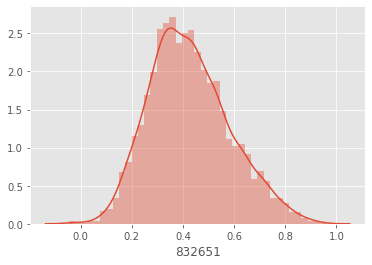

In [697]:
sns.distplot(all_fc_data.iloc[889,:])

<AxesSubplot:>

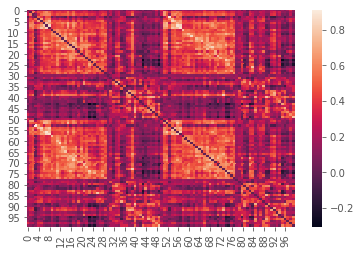

In [698]:
s = 0

sns.heatmap(sc.spatial.distance.squareform(all_fc_data.iloc[s,:]))


# CPM model

In [699]:
subj_list = all_fc_data.index 
subj_list

Int64Index([100206, 100307, 100408, 100610, 101006, 101107, 101309, 101915,
            102008, 102311,
            ...
            987074, 987983, 989987, 990366, 991267, 992673, 992774, 993675,
            994273, 996782],
           dtype='int64', length=990)

<AxesSubplot:xlabel='z_score_compare_f'>

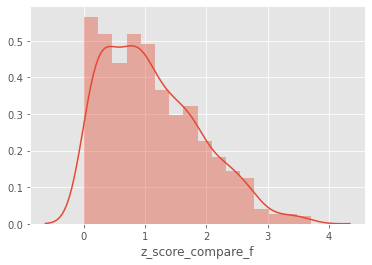

In [724]:
#Behavior
behav_list = ["Mars_Final", "z_score_mars", "DDisc_AUC_40K", "z_score_DDisc_AUC", 'Flanker_AgeAdj', 'z_score_Flanker', 'z_score_compare_f', 'z_score_compare']

behav = df[behav_list[6]]

sns.distplot(behav)


## Mars Contrast - convert to integers (ordinal regression)

In [369]:
sorted_unique = np.sort(behav.unique())
sorted_unique

array([-1.36778614, -0.63068451, -0.40955402, -0.33584386, -0.26213369,
       -0.18842353, -0.11471337, -0.04100321, -0.02257567,  0.03270696,
        0.10641712,  0.1432722 ,  0.18012728])

In [306]:
behav_list = behav.tolist()
behav_list

[1.84,
 1.76,
 1.68,
 1.88,
 1.8,
 1.84,
 1.8,
 1.8,
 1.8,
 1.8,
 1.92,
 1.76,
 1.84,
 1.68,
 1.84,
 1.8,
 1.76,
 1.76,
 1.84,
 1.84,
 1.8,
 1.88,
 1.8,
 1.8,
 1.76,
 1.84,
 1.8,
 1.84,
 1.76,
 1.68,
 1.8,
 1.88,
 1.88,
 1.76,
 1.8,
 1.8,
 1.84,
 1.72,
 1.72,
 1.72,
 1.8,
 1.8,
 1.84,
 1.76,
 1.76,
 1.84,
 1.8,
 1.88,
 1.8,
 1.68,
 1.72,
 1.76,
 1.84,
 1.8,
 1.92,
 1.72,
 1.8,
 1.76,
 1.84,
 1.76,
 1.8,
 1.92,
 1.88,
 1.8,
 1.8,
 1.92,
 1.76,
 1.8,
 1.84,
 1.76,
 1.76,
 1.92,
 1.68,
 1.8,
 1.8,
 1.76,
 1.76,
 1.88,
 1.84,
 1.88,
 1.8,
 1.88,
 1.72,
 1.84,
 1.88,
 1.8,
 1.8,
 1.76,
 1.76,
 1.8,
 1.8,
 1.76,
 1.8,
 1.64,
 1.8,
 1.72,
 1.76,
 1.8,
 1.76,
 1.8,
 1.8,
 1.76,
 1.8,
 1.8,
 1.72,
 1.8,
 1.76,
 1.92,
 1.8,
 1.72,
 1.8,
 1.84,
 1.72,
 1.88,
 1.76,
 1.88,
 1.84,
 1.84,
 1.76,
 1.8,
 1.76,
 1.76,
 1.84,
 1.76,
 1.72,
 1.72,
 1.8,
 1.72,
 1.88,
 1.72,
 1.84,
 1.8,
 1.84,
 1.88,
 1.76,
 1.68,
 1.8,
 1.92,
 1.84,
 1.88,
 1.84,
 1.8,
 1.68,
 1.72,
 1.72,
 1.88,
 1.76,
 1.92,
 1.8,
 1.

In [309]:
range(len(sorted_unique))

range(0, 13)

In [320]:
behav.iloc[0]

1.84

In [42]:
#behav_list = behav.tolist()
for i in range(len(behav)):
    for j in range(len(sorted_unique)):
        if behav.iloc[i] == sorted_unique[j]:
            behav.iloc[i] = int(j)
            

/home/lizakson/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [366]:
behav = behav.astype(int)

In [43]:
behav

Subject
100206     9.0
100307     6.0
100408     4.0
100610    10.0
101006     7.0
          ... 
992673     7.0
992774     6.0
993675     6.0
994273     6.0
996782     9.0
Name: Mars_Final, Length: 990, dtype: float64

<AxesSubplot:xlabel='Mars_Final'>

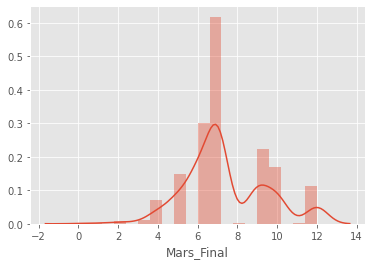

In [44]:
sns.distplot(behav)

<AxesSubplot:xlabel='z_score_compare_scaled'>

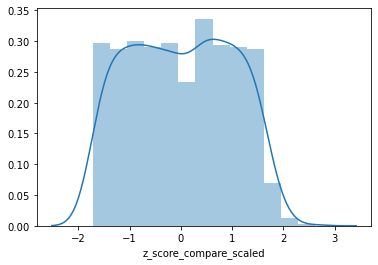

In [13]:
#Scaling the z_compare_f variable
from sklearn import preprocessing

df['z_score_compare_scaled'] = preprocessing.scale(df['z_score_compare'])

behav = df['z_score_compare_scaled']

sns.distplot(behav)

In [725]:
#Make sure the subject lists in the fMRI data and behavior data are equal
assert all_fc_data.index.equals(df.index), "Row (subject) indices of FC vcts and behavior don't match!"

## Train-test split

In [728]:
from sklearn.model_selection import train_test_split

# Split the sample to training/validation with a 60/40 ratio, and 
# stratify by neuroticsm score, and also shuffle the data.

score_y = behav

X_train, X_test, y_train, y_test = train_test_split(
                                                    all_fc_data, # x
                                                    score_y, # y
                                                    test_size = 0.5, # 60%/40% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    #stratify = score_n,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_test))

training: 495 testing: 495


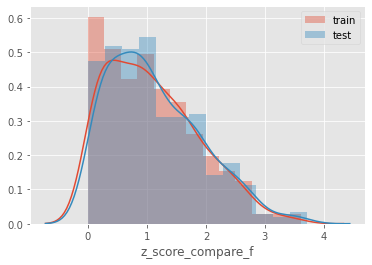

In [729]:
#Examine the distributions of y_train and y_test
sns.distplot(y_train,label='train')
sns.distplot(y_test,label='test')
plt.legend()

## Feature selection

In [730]:
import feature_selec_functions
import importlib

importlib.reload(feature_selec_functions)

mask_dict = feature_selec_functions.select_features(X_train, y_train, percent = 0.05, corr_type='pearson', verbose=False)
print(len(mask_dict[mask_dict == True]))
print(mask_dict)

#Make sure there are also negetaive edges

0.09144751524848738
(0, 30)    -0.094577
(0, 31)    -0.093210
(0, 32)    -0.096961
(0, 40)    -0.095074
(0, 79)    -0.109409
              ...   
(91, 97)   -0.122890
(91, 98)   -0.098436
(91, 99)   -0.097714
(92, 93)   -0.095512
(92, 96)   -0.099239
Length: 247, dtype: float64
4950
247
(0, 1)      False
(0, 2)      False
(0, 3)      False
(0, 4)      False
(0, 5)      False
            ...  
(96, 98)    False
(96, 99)    False
(97, 98)    False
(97, 99)    False
(98, 99)    False
Length: 4950, dtype: bool


In [731]:
print(mask_dict[mask_dict == True])

(0, 30)     True
(0, 31)     True
(0, 32)     True
(0, 40)     True
(0, 79)     True
            ... 
(91, 97)    True
(91, 98)    True
(91, 99)    True
(92, 93)    True
(92, 96)    True
Length: 247, dtype: bool


In [732]:
#Take only the selected features
X_train_selec = X_train[mask_dict.index[mask_dict]]
X_train_selec.shape

(495, 247)

In [733]:
X_train_selec

(0, 30)   (0, 31)   (0, 32)   (0, 40)   (0, 79)   (0, 90)   (0, 91)  \
161731  0.184780  0.370755  0.341536  0.456416  0.281605  0.392500  0.417521   
106521  0.037259  0.072360  0.165866  0.167080  0.049543  0.208687  0.059347   
567052  0.012793  0.130610  0.149204  0.157287  0.042522  0.110306  0.037834   
100206  0.091406  0.254747  0.119898  0.153727  0.211082  0.144514  0.240160   
116524  0.192623  0.374301  0.198557  0.364469  0.351670  0.274586  0.343695   
...          ...       ...       ...       ...       ...       ...       ...   
123117  0.060164  0.054456  0.086692  0.100771  0.094023  0.026770  0.050107   
173334  0.165569  0.242818  0.300098  0.322094  0.287929  0.249272  0.267355   
187345  0.087508  0.428646  0.170425  0.282078  0.436675  0.272182  0.479285   
182032  0.146888  0.295646  0.286348  0.251510  0.280215  0.288761  0.316550   
223929  0.285224  0.290508  0.279712  0.247279  0.201062  0.330851  0.287788   

         (1, 78)   (2, 32)   (2, 47)  ...  (90, 95)  (90, 97)  (91, 93)  \
161731  0.149975  0.274625  0.237459  ...  0.353338  0.616180  0.187711   
106521  0.098071  0.144968  0.147020  ...  0.366768  0.514605  0.059564   
567052  0.095602  0.133559  0.001801  ...  0.347077  0.500362  0.073945   
100206  0.212167  0.056760  0.053067  ...  0.450124  0.441211  0.320793   
116524  0.204860  0.154501  0.478222  ...  0.388873  0.560490  0.365693   
...          ...       ...       ...  ...       ...       ...       ...   
123117  0.043780  0.058306  0.047491  ...  0.245363  0.421556  0.193834   
173334  0.319104  0.415777  0.422791  ...  0.398218  0.708285  0.318344   
187345  0.089494  0.199001  0.193651  ...  0.346998  0.587641  0.155134   
182032  0.164809  0.126944  0.202204  ...  0.337676  0.602734  0.383232   
223929  0.284616  0.265045  0.302376  ...  0.340951  0.671299  0.464304   

        (91, 95)  (91, 96)  (91, 97)  (91, 98)  (91, 99)  (92, 93)  (92, 96)  
161731  0.226693  0.295912  0.310341  0.458577  0.297844  0.265518  0.486883  
106521  0.121704  0.313918  0.033405  0.096617  0.224467  0.138215  0.451354  
567052  0.208176  0.184264  0.009254  0.076860  0.156502  0.333957  0.511685  
100206  0.232117  0.317598  0.066495  0.217608  0.125603  0.426364  0.420964  
116524  0.488510  0.528752  0.315367  0.362770  0.552020  0.426564  0.592959  
...          ...       ...       ...       ...       ...       ...       ...  
123117  0.115685  0.228897 -0.009737  0.117352  0.146104  0.306509  0.374821  
173334  0.345982  0.414981  0.305227  0.359974  0.330296  0.392344  0.546632  
187345  0.275490  0.239893  0.251189  0.439388  0.316112  0.269450  0.428961  
182032  0.428478  0.490596  0.362635  0.283268  0.467999  0.436895  0.591560  
223929  0.435426  0.398149  0.291816  0.413366  0.370719  0.541860  0.516490  

[495 rows x 247 columns]

# RidgeCPM: Linear regression with elastic net regularization

In [626]:
#Hyperparameter tuning
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet

X, y = X_train_selec, y_train

# define model
model = ElasticNet()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.01)

# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# perform the search
results = search.fit(X, y)

# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

KeyboardInterrupt: 

In [734]:
#Cross-validation - model evaluation
#X_train = principalComponents

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

X, y = X_train_selec, y_train

model = ElasticNet(alpha=1.0, l1_ratio=0.0001) # define the model

# predict
y_pred = cross_val_predict(model, X, y, cv=10)
# scores
acc = cross_val_score(model, X, y, cv=10)
mae = cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error')

In [735]:
for i in range(10):
    print('Fold {} Acc = {}, MAE = {}'.format(i, -acc[i], -mae[i]))

Fold 0 Acc = -0.015771083490545457, MAE = 0.6466110790951454
Fold 1 Acc = 0.01607847912570337, MAE = 0.7743859694388157
Fold 2 Acc = 0.08181709012497462, MAE = 0.633699058303865
Fold 3 Acc = -0.01604340546960281, MAE = 0.6468850248441221
Fold 4 Acc = -0.014847247664217189, MAE = 0.6513658475964945
Fold 5 Acc = -0.03327313258660047, MAE = 0.5877658202198822
Fold 6 Acc = 0.007945853480709086, MAE = 0.5705630964676162
Fold 7 Acc = 0.01866665354527841, MAE = 0.6485983898127208
Fold 8 Acc = 0.008884502547386708, MAE = 0.6036063773328507
Fold 9 Acc = 0.018509785890078012, MAE = 0.6616604660468951


In [736]:
#aggregated models cross validation error 
np.mean(np.sqrt(-mae))

0.8009246965969112

R2: -0.007696704466555904
MAE: 0.6427977016324049


Text(0, 0.5, 'y_pred')

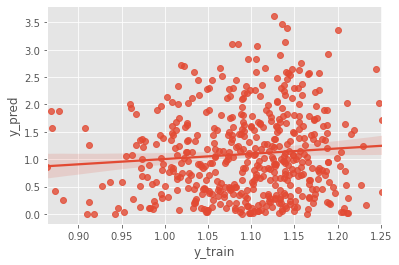

In [737]:
from sklearn.metrics import r2_score

overall_acc = r2_score(y_train, y_pred)
overall_mae = mean_absolute_error(y_train,y_pred)
print('R2:',-overall_acc)
print('MAE:',overall_mae)

sns.regplot(y_pred, y_train)
plt.xlabel('y_train')
plt.ylabel('y_pred')

In [738]:
#Take only the selected features from the test data
X_test = X_test[mask_dict.index[mask_dict]]
X_test.shape

(495, 247)

In [739]:
# define model
model = ElasticNet(alpha=1.0, l1_ratio=0.0001)

model.fit(X_train_selec, y_train)
yhat = model.predict(X_test)


R2: -0.007812047042684567
MAE: 0.6447442224162033


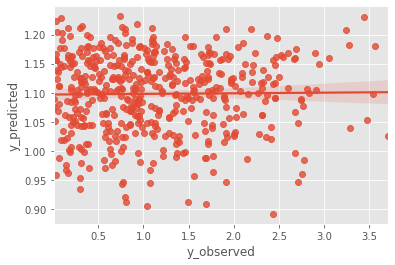

In [740]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

overall_acc = r2_score(y_test, yhat)
overall_mae = mean_absolute_error(y_test, yhat)
print('R2:',overall_acc)
print('MAE:',overall_mae)

sns.regplot(y_test, yhat)

plt.xlabel('y_observed')
plt.ylabel('y_predicted')

plt.show()

<AxesSubplot:xlabel='z_score_compare_f'>

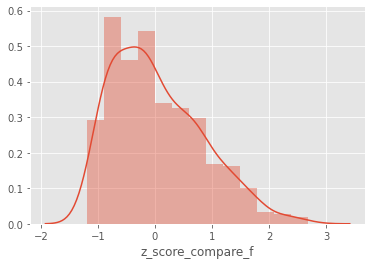

In [741]:
#Error distribution
error = y_test - yhat

sns.distplot(error)

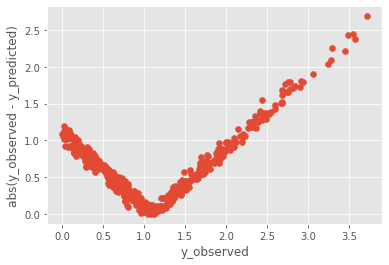

In [742]:
#Correlation between y_observed and error
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

x = y_test
y = abs(error)

#sc.stats.pearsonr(x, y)

plt.scatter(x, y)

#sns.regplot(x, y)
plt.xlabel('y_observed')
plt.ylabel('abs(y_observed - y_predicted)')

plt.show()

# Examine significance - permutation test

In [743]:
#the permutation test as "how many times obtain a correlation coefficient that is greater than the observed value?"
from mlxtend.evaluate import permutation_test
#link: http://rasbt.github.io/mlxtend/user_guide/evaluate/permutation_test/
x, y = y_test, yhat

print('Observed pearson R: %.2f' % np.corrcoef(x, y)[1][0])


p_value = permutation_test(x, y,
                           method='approximate', num_rounds=10000,
                           func=lambda x, y: np.corrcoef(x, y)[1][0],
                           seed=0)
print('P value: %.2f' % p_value)

Observed pearson R: 0.01
P value: 0.40


# Relevant features for prediction

In [716]:
import feature_selec_functions
import importlib

importlib.reload(feature_selec_functions)

model_coefs = model.coef_
#model_coefs = model_coefs.flatten() #needed for the SVR model

#model_coefs
print("Number of coefs is {}".format(len(model_coefs)))

#The thr of the highest 10% of the features
thr = feature_selec_functions.Pmaxelements(model_coefs, 0.5)

mask = np.logical_or(model_coefs>=thr, model_coefs<=-thr)
relevant_features = model_coefs[mask]

relevant_features
#np.sum(relevant_features)
#relevant_features #mask of relevant features

Number of coefs is 247


array([-0.18291561, -0.39882109,  0.1016895 ,  0.09602686, -0.14671042,
        0.06987894,  0.22419869, -0.14043081, -0.06299798,  0.06572064,
       -0.0772266 ,  0.33037082,  0.21447967,  0.09146205,  0.1770102 ,
        0.17416902,  0.15644572,  0.20544621,  0.0759974 ,  0.08974295,
        0.24387766, -0.10317162, -0.18167458, -0.29949956, -0.11937592,
       -0.20744442, -0.29477515, -0.18497513, -0.13323868, -0.06616728,
       -0.18934559, -0.095183  ,  0.25269389, -0.06203885,  0.46855242,
        0.17053207,  0.164368  ,  0.05991355, -0.13923225, -0.06581661,
        0.05677495,  0.0774368 ,  0.12615729,  0.06244186, -0.13970192,
        0.36422273,  0.07473308, -0.15611705,  0.14592332,  0.09696314,
        0.14824506,  0.16949925,  0.11763506,  0.14862588,  0.12179097,
        0.11912218,  0.11613383,  0.26719881,  0.06137683, -0.14697441,
       -0.41453148,  0.30045638, -0.12642876,  0.22785325,  0.19943421,
       -0.10181359, -0.08435006, -0.06498691, -0.10868028, -0.14

In [717]:
rel_features = X_train_selec.columns[mask]
rel_features 

Index([  (1, 3),   (1, 4),  (1, 76),  (3, 26),  (3, 42),  (3, 76),  (3, 84),
        (3, 90),  (4, 23),  (4, 27),
       ...
       (83, 99), (85, 99), (86, 95), (86, 97), (88, 95), (89, 96), (90, 98),
       (91, 96), (92, 93), (93, 94)],
      dtype='object', length=123)

In [586]:
rel_features[0]

(0, 56)

## Combine relevant features, their identity and betas

In [772]:
#path to parcellation labels 
path_label = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/Parcellations/Parcellations/HCP/fslr32k/cifti/Schaefer2018_100Parcels_7Networks_order_info.txt'

with open(path_label, 'r') as f:
    lines = f.readlines()
    
lines

['7Networks_LH_Vis_1\n',
 '1 120 18 131 255\n',
 '7Networks_LH_Vis_2\n',
 '2 120 18 132 255\n',
 '7Networks_LH_Vis_3\n',
 '3 120 18 133 255\n',
 '7Networks_LH_Vis_4\n',
 '4 120 18 135 255\n',
 '7Networks_LH_Vis_5\n',
 '5 120 18 136 255\n',
 '7Networks_LH_Vis_6\n',
 '6 120 18 137 255\n',
 '7Networks_LH_Vis_7\n',
 '7 120 18 138 255\n',
 '7Networks_LH_Vis_8\n',
 '8 120 18 139 255\n',
 '7Networks_LH_Vis_9\n',
 '9 120 18 140 255\n',
 '7Networks_LH_SomMot_1\n',
 '10 70 130 179 255\n',
 '7Networks_LH_SomMot_2\n',
 '11 70 130 181 255\n',
 '7Networks_LH_SomMot_3\n',
 '12 70 130 182 255\n',
 '7Networks_LH_SomMot_4\n',
 '13 70 130 183 255\n',
 '7Networks_LH_SomMot_5\n',
 '14 70 130 184 255\n',
 '7Networks_LH_SomMot_6\n',
 '15 70 130 185 255\n',
 '7Networks_LH_DorsAttn_Post_1\n',
 '16 0 118 13 255\n',
 '7Networks_LH_DorsAttn_Post_2\n',
 '17 0 118 15 255\n',
 '7Networks_LH_DorsAttn_Post_3\n',
 '18 0 118 16 255\n',
 '7Networks_LH_DorsAttn_Post_4\n',
 '19 0 118 17 255\n',
 '7Networks_LH_DorsAttn_Post

In [791]:
lines[1][2:-5]

'1'

In [787]:
#list of coordinates
list_coordinates = []
for i in range(1, len(lines), 2): #only odd rows
    list_coordinates.append(lines[i][2:-5])
#len(list_parcel)
list_coordinates

['120 18 131',
 '120 18 132',
 '120 18 133',
 '120 18 135',
 '120 18 136',
 '120 18 137',
 '120 18 138',
 '120 18 139',
 '120 18 140',
 ' 70 130 179',
 ' 70 130 181',
 ' 70 130 182',
 ' 70 130 183',
 ' 70 130 184',
 ' 70 130 185',
 ' 0 118 13',
 ' 0 118 15',
 ' 0 118 16',
 ' 0 118 17',
 ' 0 118 18',
 ' 0 118 19',
 ' 0 118 20',
 ' 0 118 21',
 ' 196 58 251',
 ' 196 59 251',
 ' 196 59 252',
 ' 196 59 253',
 ' 197 58 251',
 ' 197 58 252',
 ' 197 58 253',
 ' 220 248 165',
 ' 220 248 166',
 ' 220 248 167',
 ' 230 148 35',
 ' 230 149 36',
 ' 231 149 35',
 ' 231 149 36',
 ' 205 62 80',
 ' 205 62 81',
 ' 205 62 82',
 ' 205 62 83',
 ' 205 63 76',
 ' 205 63 77',
 ' 205 63 79',
 ' 205 63 80',
 ' 205 63 81',
 ' 205 63 82',
 ' 205 63 83',
 ' 205 63 84',
 ' 205 63 85',
 ' 124 18 133',
 ' 124 18 134',
 ' 124 18 136',
 ' 124 18 137',
 ' 124 18 138',
 ' 124 18 139',
 ' 124 18 140',
 ' 124 18 141',
 ' 74 130 179',
 ' 74 130 180',
 ' 74 130 182',
 ' 74 130 183',
 ' 74 130 184',
 ' 74 130 185',
 ' 74 130 1

In [719]:
#list of parcels
list_parcel = []
for i in range(0, len(lines), 2): #only even rows
    list_parcel.append(lines[i][10:-1])
#len(list_parcel)
list_parcel

['LH_Vis_1',
 'LH_Vis_2',
 'LH_Vis_3',
 'LH_Vis_4',
 'LH_Vis_5',
 'LH_Vis_6',
 'LH_Vis_7',
 'LH_Vis_8',
 'LH_Vis_9',
 'LH_SomMot_1',
 'LH_SomMot_2',
 'LH_SomMot_3',
 'LH_SomMot_4',
 'LH_SomMot_5',
 'LH_SomMot_6',
 'LH_DorsAttn_Post_1',
 'LH_DorsAttn_Post_2',
 'LH_DorsAttn_Post_3',
 'LH_DorsAttn_Post_4',
 'LH_DorsAttn_Post_5',
 'LH_DorsAttn_Post_6',
 'LH_DorsAttn_PrCv_1',
 'LH_DorsAttn_FEF_1',
 'LH_SalVentAttn_ParOper_1',
 'LH_SalVentAttn_FrOperIns_1',
 'LH_SalVentAttn_FrOperIns_2',
 'LH_SalVentAttn_PFCl_1',
 'LH_SalVentAttn_Med_1',
 'LH_SalVentAttn_Med_2',
 'LH_SalVentAttn_Med_3',
 'LH_Limbic_OFC_1',
 'LH_Limbic_TempPole_1',
 'LH_Limbic_TempPole_2',
 'LH_Cont_Par_1',
 'LH_Cont_PFCl_1',
 'LH_Cont_pCun_1',
 'LH_Cont_Cing_1',
 'LH_Default_Temp_1',
 'LH_Default_Temp_2',
 'LH_Default_Par_1',
 'LH_Default_Par_2',
 'LH_Default_PFC_1',
 'LH_Default_PFC_2',
 'LH_Default_PFC_3',
 'LH_Default_PFC_4',
 'LH_Default_PFC_5',
 'LH_Default_PFC_6',
 'LH_Default_PFC_7',
 'LH_Default_pCunPCC_1',
 'LH_Defa

In [720]:
#create a list of dictionaries which identifies each relevant pair of nodes and attach its beta
res = []
for i in range(len(rel_features)):
    dict_res = {}
    tup = rel_features[i] #tupple(pair of nodes)
    parcel_index = tup[0] #tupples and list_parcels are listed from zero
    dict_res["node1"] = list_parcel[parcel_index]
    parcel_index = tup[1]
    dict_res["node2"] = list_parcel[parcel_index]
    dict_res["beta"] = relevant_features[i]
    res.append(dict_res)
res

[{'node1': 'LH_Vis_2', 'node2': 'LH_Vis_4', 'beta': -0.18291561049081112},
 {'node1': 'LH_Vis_2', 'node2': 'LH_Vis_5', 'beta': -0.3988210926184967},
 {'node1': 'LH_Vis_2',
  'node2': 'RH_SalVentAttn_Med_1',
  'beta': 0.10168949614363935},
 {'node1': 'LH_Vis_4',
  'node2': 'LH_SalVentAttn_PFCl_1',
  'beta': 0.0960268630281308},
 {'node1': 'LH_Vis_4',
  'node2': 'LH_Default_PFC_2',
  'beta': -0.1467104192816628},
 {'node1': 'LH_Vis_4',
  'node2': 'RH_SalVentAttn_Med_1',
  'beta': 0.06987893991857672},
 {'node1': 'LH_Vis_4', 'node2': 'RH_Cont_PFCl_3', 'beta': 0.22419868682493274},
 {'node1': 'LH_Vis_4',
  'node2': 'RH_Default_Temp_1',
  'beta': -0.14043080986924278},
 {'node1': 'LH_Vis_5',
  'node2': 'LH_SalVentAttn_ParOper_1',
  'beta': -0.06299797726737591},
 {'node1': 'LH_Vis_5',
  'node2': 'LH_SalVentAttn_Med_1',
  'beta': 0.06572064257343312},
 {'node1': 'LH_Vis_5',
  'node2': 'LH_Default_PFC_3',
  'beta': -0.07722660207750913},
 {'node1': 'LH_Vis_5',
  'node2': 'RH_SalVentAttn_Med_1

In [722]:
df_res = pd.DataFrame(res)
df_res

node1                  node2      beta
0             LH_Vis_2               LH_Vis_4 -0.182916
1             LH_Vis_2               LH_Vis_5 -0.398821
2             LH_Vis_2   RH_SalVentAttn_Med_1  0.101689
3             LH_Vis_4  LH_SalVentAttn_PFCl_1  0.096027
4             LH_Vis_4       LH_Default_PFC_2 -0.146710
..                 ...                    ...       ...
118   RH_Default_Par_1  RH_Default_PFCdPFCm_2  0.132294
119  RH_Default_Temp_1   RH_Default_pCunPCC_1 -0.397474
120  RH_Default_Temp_2  RH_Default_PFCdPFCm_2 -0.197365
121  RH_Default_Temp_3      RH_Default_PFCv_1  0.310444
122  RH_Default_PFCv_1      RH_Default_PFCv_2  0.160968

[123 rows x 3 columns]

In [723]:
df_res.to_csv('df_F.csv') #Change name of file according to the task

# SVR model

In [745]:
#Cross-validation
#X_train = principalComponents

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

X, y = X_train_selec, y_train

l_svr = SVR(kernel='poly', C = 0.0001) # define the model

# predict
y_pred = cross_val_predict(l_svr, X, y, cv=10)
# scores
acc = cross_val_score(l_svr, X, y, cv=10)
mae = cross_val_score(l_svr, X, y, cv=10, scoring='neg_mean_absolute_error')

In [746]:
for i in range(10):
    print('Fold {} Acc = {}, MAE = {}'.format(i, acc[i], -mae[i]))

Fold 0 Acc = -0.017399783606939945, MAE = 0.6461493988566828
Fold 1 Acc = -0.015983902395320104, MAE = 0.7636382231262655
Fold 2 Acc = -0.02024264914124152, MAE = 0.6030507535517329
Fold 3 Acc = -0.042465315408016346, MAE = 0.6590455739683475
Fold 4 Acc = 0.0160003667959574, MAE = 0.6349935127035378
Fold 5 Acc = 0.007952636978195482, MAE = 0.5822583570228618
Fold 6 Acc = 0.009570277344378098, MAE = 0.5440035259312014
Fold 7 Acc = -0.02868712899857284, MAE = 0.6404188920039501
Fold 8 Acc = -0.11978624358463819, MAE = 0.6297878820349936
Fold 9 Acc = -0.1073749913647295, MAE = 0.6668333994713241


In [747]:
#aggregated models cross validation error 
np.mean(np.sqrt(-mae))

0.7974019297369372

In [414]:
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold


# define model
model = SVR(kernel='linear', C = 0.01)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(model, X_train_selec, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.086 (0.011)


In [744]:
#Hyperparameter tuning
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold


X, y = X_train_selec, y_train

# define model
model = SVR()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid
grid = dict()
grid['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['kernel'] = ['linear', 'rbf', 'poly']

# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# perform the search
results = search.fit(X, y)

# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.639
Config: {'C': 0.0001, 'kernel': 'poly'}


R2: 0.018306873082881925
MAE: 0.6372639876304658


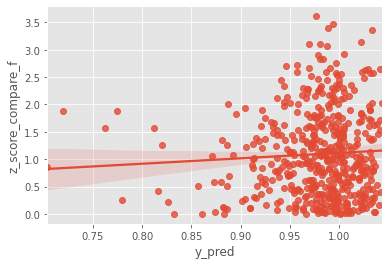

In [748]:
from sklearn.metrics import r2_score

overall_acc = r2_score(y_train, y_pred)
overall_mae = mean_absolute_error(y_train,y_pred)
print('R2:',-overall_acc)
print('MAE:',overall_mae)

sns.regplot(y_pred, y_train)
plt.xlabel('y_train')
plt.xlabel('y_pred')

plt.show()

In [749]:
#Take only the selected features from the test data
X_test = X_test[mask_dict.index[mask_dict]]
X_test.shape

(495, 247)

In [750]:
l_svr.fit(X_train_selec, y_train)
yhat = l_svr.predict(X_test)

R2: -0.04228021815789007
MAE: 0.6358185002195401


Text(0, 0.5, 'y_predicted')

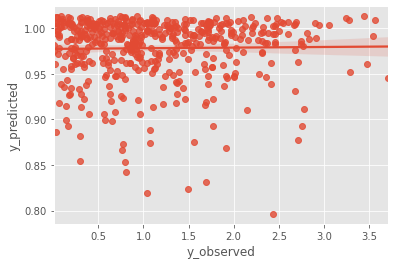

In [751]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

overall_acc = r2_score(y_test, yhat)
overall_mae = mean_absolute_error(y_test, yhat)
print('R2:',overall_acc)
print('MAE:',overall_mae)

sns.regplot(y_test, yhat)
plt.xlabel('y_observed')
plt.ylabel('y_predicted')

<AxesSubplot:xlabel='z_score_compare_f'>

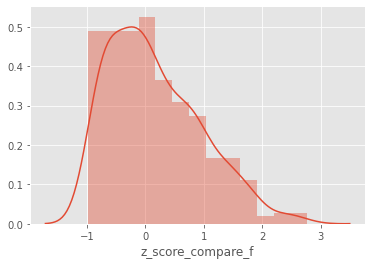

In [752]:
#Error distribution
error = y_test - yhat

sns.distplot(error)

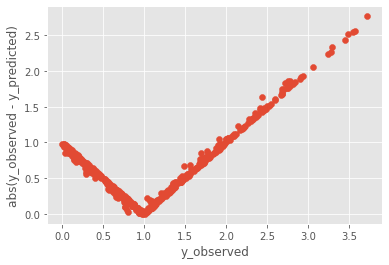

In [753]:
#Correlation between y_observed and error
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

x = y_test
y = abs(error)

#sc.stats.pearsonr(x, y)

plt.scatter(x, y)

#sns.regplot(x, y)
plt.xlabel('y_observed')
plt.ylabel('abs(y_observed - y_predicted)')

plt.show()

# Examine significance - permutation test

In [763]:
#the permutation test as "how many times obtain a correlation coefficient that is greater than the observed value?"
from mlxtend.evaluate import permutation_test
#link: http://rasbt.github.io/mlxtend/user_guide/evaluate/permutation_test/
x, y = y_test, yhat

print('Observed pearson R: %.2f' % np.corrcoef(x, y)[1][0])


p_value = permutation_test(x, y,
                           method='approximate', num_rounds=10000,
                           func=lambda x, y: np.corrcoef(x, y)[1][0],
                           seed=0)
print('P value: %.2f' % p_value)

Observed pearson R: 0.01
P value: 0.40


In [610]:
import feature_selec_functions
import importlib

importlib.reload(feature_selec_functions)

model_coefs = l_svr.coef_
model_coefs = model_coefs.flatten()
#model_coefs


print("Number of coefs is {}".format(len(model_coefs)))

#The thr of the highest 10% of the features
thr = feature_selec_functions.Pmaxelements(model_coefs, 0.5)

print(thr)

mask = np.logical_or(model_coefs>=thr, model_coefs<=-thr)
relevant_features = model_coefs[mask]

relevant_features
#np.sum(relevant_features)
#relevant_features #mask of relevant features

Number of coefs is 247
0.0048451108299336545


array([ 0.01367114,  0.01890713, -0.00520117,  0.00807081,  0.01223342,
       -0.01478416, -0.01040637, -0.01454277, -0.01511767,  0.02356414,
        0.02772884,  0.01083397,  0.02285146,  0.01053463, -0.0076621 ,
       -0.00749919,  0.00746618, -0.01294413,  0.00617739,  0.02867295,
        0.00530089, -0.01493846, -0.01270871, -0.00580483, -0.00599668,
       -0.00974654, -0.0090683 , -0.00591987,  0.0079215 ,  0.00826919,
        0.0156325 ,  0.02041919, -0.00690729,  0.01057267,  0.01619039,
       -0.01149071, -0.00772243, -0.00642527,  0.02074304, -0.00874261,
       -0.0104502 , -0.01278043,  0.01946986, -0.01504819, -0.01305264,
       -0.00513061, -0.01585979, -0.00942032,  0.01456948,  0.01879101,
        0.01731193,  0.02748278, -0.0156353 ,  0.00779963, -0.01184264,
        0.01459048,  0.01516298,  0.01761619,  0.01290824,  0.01688393,
        0.01161787, -0.014783  ,  0.01398599,  0.00659866,  0.02357103,
       -0.01124829, -0.00514345, -0.01679623, -0.01185176, -0.01

In [611]:
rel_features_MC = X_train_selec.columns[mask]
rel_features_MC 

Index([  (2, 4),   (2, 7),  (2, 45),  (2, 54),  (2, 57),  (2, 96),   (3, 5),
        (3, 23),  (3, 55),   (4, 6),
       ...
       (79, 93), (80, 83), (82, 83), (82, 84), (82, 97), (83, 84), (83, 88),
       (85, 96), (89, 93), (96, 98)],
      dtype='object', length=123)

In [442]:
with open('rel_features_MC.csv', 'w') as f:
    writer = csv.writer(f , lineterminator='\n')
    for tup in rel_features_MC:
        writer.writerow(tup)

# Model for gamma distribution (z_compare_f)

In [755]:
#Hyperparameter tuning
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import GammaRegressor


X, y = X_train_selec, y_train

# define model
model = GammaRegressor()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]

# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# perform the search
results = search.fit(X, y)

# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.644
Config: {'alpha': 1.0}


In [756]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import GammaRegressor

X, y = X_train_selec, y_train

model = GammaRegressor(alpha=1.0, fit_intercept=True, max_iter=100, tol=0.0001, warm_start=False, verbose=0) # define the model

# predict
y_pred = cross_val_predict(model, X, y, cv=10)
# scores
acc = cross_val_score(model, X, y, cv=10)
mae = cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error')

In [757]:
for i in range(10):
    print('Fold {} -- Acc = {}, MAE = {}'.format(i, acc[i], -mae[i]))

Fold 0 -- Acc = 0.009472018046186248, MAE = 0.6461487538031147
Fold 1 -- Acc = -0.007738157385525746, MAE = 0.7750970665118428
Fold 2 -- Acc = -0.03539525810484667, MAE = 0.6321670126754395
Fold 3 -- Acc = 0.009781375963308636, MAE = 0.6466282479634823
Fold 4 -- Acc = 0.013218591552482728, MAE = 0.6510073679263444
Fold 5 -- Acc = 0.01700637977630781, MAE = 0.5879487625870156
Fold 6 -- Acc = -0.003187589761792564, MAE = 0.5698273770939437
Fold 7 -- Acc = -0.012215108520711615, MAE = 0.6466794287497738
Fold 8 -- Acc = -0.005285436663003074, MAE = 0.6037882897628384
Fold 9 -- Acc = -0.014901519630576843, MAE = 0.6614305561886703


In [758]:
#aggregated models cross validation error 
np.mean(np.sqrt(-mae))

0.8006434380225599

R2: 0.007905466115554094
MAE: 0.6423565025227091


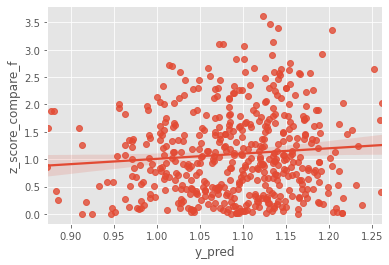

In [759]:
from sklearn.metrics import r2_score

overall_acc = r2_score(y_train, y_pred)
overall_mae = mean_absolute_error(y_train,y_pred)
print('R2:',overall_acc)
print('MAE:',overall_mae)

sns.regplot(y_pred, y_train)
plt.xlabel('y_train')
plt.xlabel('y_pred')

plt.show()

In [760]:
#Take only the selected features from the test data
X_test = X_test[mask_dict.index[mask_dict]]
X_test.shape

(495, 247)

In [761]:
model.fit(X_train_selec, y_train)
yhat = model.predict(X_test)

R2: -0.008534892906300273
MAE: 0.6446094303925965


Text(0, 0.5, 'y_predicted')

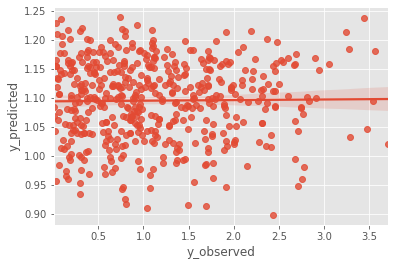

In [762]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

overall_acc = r2_score(y_test, yhat)
overall_mae = mean_absolute_error(y_test, yhat)
print('R2:',overall_acc)
print('MAE:',overall_mae)

sns.regplot(y_test, yhat)
plt.xlabel('y_observed')
plt.ylabel('y_predicted')

# Model for ordinal data (Mars Contrast) 

In [129]:
# choose models
from sklearn.linear_model import LinearRegression, LogisticRegression
from mord import LogisticAT

# instantiate models
model_linear = LinearRegression()
model_1vR = LogisticRegression(multi_class='ovr',
    class_weight='balanced')
model_multi = LogisticRegression(multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced')
model_ordinal = LogisticAT(alpha=0)  # alpha parameter set to zero to perform no regularisation

In [38]:
from mord import LogisticAT

model_ordinal = LogisticAT(alpha=0)  # alpha parameter set to zero to perform no regularisation

In [377]:
from mord import LogisticAT

X, y = X_train_selec, y_train

model_ordinal = LogisticAT(alpha=0)  # alpha parameter set to zero to perform no regularisation

# predict
y_pred = cross_val_predict(model_ordinal, X, y, cv=11)
# scores
acc = cross_val_score(model_ordinal, X, y, cv=11)
mae = cross_val_score(model_ordinal, X, y, cv=11, scoring='neg_mean_absolute_error')

ValueError: Values in y must be [ 0  1  2  3  4  5  6  7  8  9 10 11], instead got [ 0  1  2  3  4  5  6  7  9 10 11 12]

# Try simple neural network - Flanker task

In [78]:
from sklearn.neural_network import MLPRegressor

X, y = X_train_selec, y_train

regr = MLPRegressor(random_state=1, max_iter=10000, learning_rate = 'adaptive', learning_rate_init=0.0001, alpha = 0.1).fit(X, y)

In [764]:
#Hyperparameter tuning
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neural_network import MLPRegressor

X, y = X_train_selec, y_train

# define model
model = MLPRegressor()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid
grid = dict()
grid['learning_rate'] = ['constant', 'invscaling', 'adaptive']
grid['learning_rate_init'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0]

# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# perform the search
results = search.fit(X, y)

# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.669
Config: {'alpha': 0.001, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001}


/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [765]:
#Cross-validation
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.neural_network import MLPRegressor

X, y = X_train_selec, y_train

regr = MLPRegressor(random_state=1, max_iter=10000, learning_rate = 'adaptive', learning_rate_init=0.0001, alpha = 0.001).fit(X, y)

# predict
y_pred = cross_val_predict(regr,X, y, cv=10)
# scores
acc = cross_val_score(regr, X, y, cv=10)
mae = cross_val_score(regr, X, y, cv=10, scoring='neg_mean_absolute_error')

In [766]:
for i in range(10):
    print('Fold {} -- Acc = {}, MAE = {}'.format(i, -acc[i], -mae[i]))

Fold 0 -- Acc = 0.8230913223610059, MAE = 0.8876756484476269
Fold 1 -- Acc = 0.7484302260780422, MAE = 0.9998331662215921
Fold 2 -- Acc = 1.3973953956979184, MAE = 0.8936084991446124
Fold 3 -- Acc = 0.08500723690155243, MAE = 0.6466411372196245
Fold 4 -- Acc = 0.8419658527600495, MAE = 0.8925126942106628
Fold 5 -- Acc = 0.9552096916878121, MAE = 0.8396710056079375
Fold 6 -- Acc = 1.183375056851506, MAE = 0.862020209698671
Fold 7 -- Acc = 0.6856429938929813, MAE = 0.8058920453394384
Fold 8 -- Acc = 0.5678592915616747, MAE = 0.7738466614893688
Fold 9 -- Acc = 0.7530968906911801, MAE = 0.8813297151010483


R2: -0.7557171463830827
MAE: 0.8484621807813992


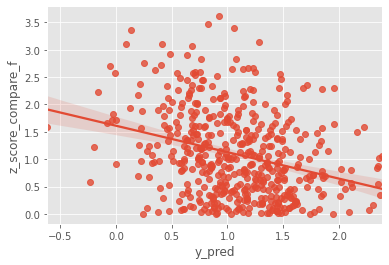

In [767]:
from sklearn.metrics import r2_score

overall_acc = r2_score(y_train, y_pred)
overall_mae = mean_absolute_error(y_train,y_pred)
print('R2:',overall_acc)
print('MAE:',overall_mae)

sns.regplot(y_pred, y_train)
plt.xlabel('y_train')
plt.xlabel('y_pred')

plt.show()

In [768]:
#Take only the selected features from the test data
X_test = X_test[mask_dict.index[mask_dict]]
X_test.shape

(495, 247)

In [769]:
regr.fit(X, y)
yhat = regr.predict(X_test)

R2: -0.2899792414335751
MAE: 0.7158942046366583


Text(0, 0.5, 'y_predicted')

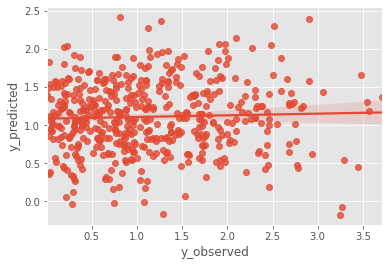

In [770]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

overall_acc = r2_score(y_test, yhat)
overall_mae = mean_absolute_error(y_test, yhat)
print('R2:',overall_acc)
print('MAE:',overall_mae)

sns.regplot(y_test, yhat)
plt.xlabel('y_observed')
plt.ylabel('y_predicted')

In [771]:
#the permutation test as "how many times obtain a correlation coefficient that is greater than the observed value?"
from mlxtend.evaluate import permutation_test
#link: http://rasbt.github.io/mlxtend/user_guide/evaluate/permutation_test/
x, y = y_test, yhat

print('Observed pearson R: %.2f' % np.corrcoef(x, y)[1][0])


p_value = permutation_test(x, y,
                           method='approximate', num_rounds=10000,
                           func=lambda x, y: np.corrcoef(x, y)[1][0],
                           seed=0)
print('P value: %.2f' % p_value)

Observed pearson R: 0.04
P value: 0.20


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

print('Ordered logistic regression: ', np.mean(MAE_ordinal))

In [ ]:
# Then we define the various classifiers that we use
classifiers = ['svc_l2', 'svc_l1', 'logistic_l1',
               'logistic_l2', 'ridge_classifier']

# Here we compute prediction scores and run time for all these
# classifiers
import time
from nilearn.decoding import Decoder
from sklearn.model_selection import LeaveOneGroupOut

cv = LeaveOneGroupOut()
classifiers_data = {}

for classifier_name in sorted(classifiers):
    classifiers_data[classifier_name] = {}
    print(70 * '_')

    # The decoder has as default score the `roc_auc`
    decoder = Decoder(estimator=classifier_name, mask=mask_filename,
                      standardize=True, cv=cv)
    t0 = time.time()
    decoder.fit(fmri_niimgs, classification_target, groups=session_labels)

    classifiers_data[classifier_name] = {}
    classifiers_data[classifier_name]['score'] = decoder.cv_scores_
    classifiers_data[classifier_name]['map'] = decoder.coef_img_['house']

    print("%10s: %.2fs" % (classifier_name, time.time() - t0))
    for category in categories:
        print("    %14s vs all -- AUC: %1.2f +- %1.2f" % (
            category,
            np.mean(classifiers_data[classifier_name]['score'][category]),
            np.std(classifiers_data[classifier_name]['score'][category]))
        )

    # Adding the average performance per estimator
    scores = classifiers_data[classifier_name]['score']
    scores['AVERAGE'] = np.mean(list(scores.values()), axis=0)
    classifiers_data[classifier_name]['score'] = scores

In [233]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn import svm

clf = svm.SVC(kernel='linear', C = 1.0)

clf.fit(X_train,y_train)

SVC(kernel='linear')

In [42]:
# use automatically configured elastic net algorithm
from numpy import arange
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
# load the dataset
X, y = X_train, y_train
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
ratios = arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
# fit model
model.fit(X, y)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)
print('l1_ratio_: %f' % model.l1_ratio_)

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131.42430802799848, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 138.36569728573, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133.55029969892092, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.44534863673684766, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.64919903452565, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4580312419924865, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4869709928456786, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.242864885843225, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.952099403730399, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9955255573874955, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.371159470590655, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.483215969047656, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.83527315795419, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.51817716293012, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.80275592826329, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.34134176031462, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.65860583373276, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96.79476640229915, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.19012827721107, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.06764955423631, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124.6395649166286, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116.26352782671677, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.69860738923071, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.510685062401436, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6770304990622305, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.52744315025006, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.021248350110262, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.21768772211725, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9228258251437973, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43812111546246046, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.51803976416232, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.05560421088551, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.938046938585515, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.369208110682292, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.642873420000647, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4167958228652891, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5202058729766198, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positi

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.117600503227997, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.16860699456636, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7718310494032616, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4390866509230722, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9509581559966875, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.2762961058935245, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.861864103475694, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.49461610336033146, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.264349978605548, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.314573273776546, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.444948871509126, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4039383595164769, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.27271708254731, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.149404560103044, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6902147909456806, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.769034033804292, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.13754187052305, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.29633644004302, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.06040636951036, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45256714095712836, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.123619044946167, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.84180781438691, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.643296000002184, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5182927822703127, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8106788744425706, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.43297545857264, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8883118208525893, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4874750568846743, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6746845695573143, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.129143342549327, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.258041371173262, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.19120566130661, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.91517069797527, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.98896849887656, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.816175838447, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wan

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.980428810508087, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.258890063218189, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.556273339268984, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.481396727953747, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7672808331584555, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43947959734912334, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4278193748177377, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9325506111071333, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.333236941366207, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.131051251159462, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.269058325504766, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6017742937327881, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8736830916534188, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4205508745180631, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8343252931592025, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.523549296395662, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3912248281872982, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5767590374758242, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7742110068553671, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7042588398787046, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5022884669659758, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4908530843450911, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positi

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.19266361511849, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.188389726570346, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.488216744307977, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45359102787083067, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6209520580279246, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45102984570993826, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39176376276111274, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positi

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.023921307321956, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.39016889530577, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.48200238099777, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3082089790865865, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.48510406016122437, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.422818520622606, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3734267709344152, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.00158508940481, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.205453174149497, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46532695575948696, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.702386845709215, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.089379982593811, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3346912590428275, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3126562081113917, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5069705365596349, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.626229489210793, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4454450171764447, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3378746568662198, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positiv

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5943868897667555, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8885489409869507, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.901084469893725, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6959768055892823, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.44428373874704524, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6654310921898245, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.16627076608678, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.239714024319992, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.212627766821985, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.012971378790354, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.223184728979813, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.253026119719891, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.430124907776786, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.443223942648556, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.231972442977955, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4617101439024904, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3568695205982095, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.304090447287166, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6729751117363962, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3802757693856194, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3839189091385975, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.960276001106524, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5499945726908195, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43137893305829167, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.380640781753506, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.34861494599563, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5755062196985108, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7274346061634844, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.38340537125856144, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.38818084281277787, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.750933026306292, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5954841974365848, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6379959923912186, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4952174847751797, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.61296885704381, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.567774489463614, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3340752771930219, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5341950182916122, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.44197499526174, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7065602267030329, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45000474275692076, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45463880205300067, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6339862602942361, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.478305308646704, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1008800135041255, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30097592638945514, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.252651033852224, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.420265648840107, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3703015093480165, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.161863470715529, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.039488708170158, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.714809284965952, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.746050235819643, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.062166280263014, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43873305106932026, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.673715738528017, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4829538968684623, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.050223522255756, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8732843120878195, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4413693607079523, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.834491658144813, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.225304319405558, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2918389763570417, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4505439425401107, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15681300262508557, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7865576541961303, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.092298466388258, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.67884190491544, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5192746727720419, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.231682809584342, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5211647366429597, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3298718967754154, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7949221841140592, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.9374851093115, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.468095556559311, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6075385395643309, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.314876793699077, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3140319806516345, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3995447923353197, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.559350310831595, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.095923210659407, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.973073302542417, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46639762380132765, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.940452925249254, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.415228767927002, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7047370261281714, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3608064296112399, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3187469796706, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.8258825833474, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.641978997823934, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4678544027498788, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13064307743317727, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.098639076449128, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You m

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.49557700627421486, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.396228797106618, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positiv

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.938091350175988, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.078590441375512, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03344671163965529, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.48990420994518, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12257116175698002, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.396653892937035, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.604731964640227, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.506538263111048, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12994983818320804, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33276583540857985, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5042682922230313, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.019657840749552, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.502351058865028, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.923258343429596, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.315057571433561, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15896868533486952, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.40072145134765685, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0932606024438769, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.223600077716604, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.20363158983463, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.389937827454774, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06155294017791846, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4396874934290649, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.508640383845715, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22340587609441798, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.161184792288247, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.565315156556288, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.739243380720675, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.097900356634296, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.484069836922522, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05787890826174191, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.44516999338436664, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21247943793359525, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.431833337480213, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.0388443891251775, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.744208464568374, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.297319146631526, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.806074876221082, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08380456579253348, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11885557373206268, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.059267428807800115, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4202316369953526, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularizati

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3972066572052734, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3169447541879142, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.267977982024476, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.12702122238681, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5113939987189399, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4279395284973353, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.425337184269967, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5147217686803218, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.49205541059057506, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positi

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.657754058605808, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4176032474692185, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.924156602503277, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.654648446759262, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.1222385004857, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5191483846716308, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1264485343520647, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.127900865039855, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04640921629255956, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3870161418301892, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5197469761915738, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4866666813249182, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positi

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.644031399185032, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4626973043394461, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.360903023151638, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.664847405441915, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4866416729450181, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1704871651153184, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1713906199164175, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.767967205186137, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.741329291370536, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.89834749482863, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.985470019584124, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5002299774926684, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7008077396752976, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.813551624656935, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0842406022245541, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7766090298251145, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.209277479269812, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7670629745238333, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.0118792704721065, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.602483050708064, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7533849353443856, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.145876430688931, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.356929816215235, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3764917779587282, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6755505768724737, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.579352361133575, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8863947608603167, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7917338931412234, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4708382257695543, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.486717454884142, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4102782069742037, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.919561097481759, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.4

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47323579903583834, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.520641284326361, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.89331110880037, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4391390167904023, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.1

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.500895285627255, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5229245988144852, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8077442445300465, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.310364696486957, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4631529440655546, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.010894717838811, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.656422703505866, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.765108160894327, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.318766754026038, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45416489341817906, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.524801327302153, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6743287920051064, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5111179321093012, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7989741051617685, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5333515650701852, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9261549392570374, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.103172579192733, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.484322206307569, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.64446381857856, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.565950978545956, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.308399280168107, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.875260984736032, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.537861665212645, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.674330149485975, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.772753646841107, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.045768808549514, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.638801629077296, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.056844924095746, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.335406513696821, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.933194650378342, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6200285310695115, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.762670760510376, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.531570360429642, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9031151071374155, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.729154670404795, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.032499159299813, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.018311735561104, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.073957383583546, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.114065952034151, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.819804052994268, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.39238579692103, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.308185976511174, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.1694839301821, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.12591848395555, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.75447576945052, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.738920319784079, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5213508111377037, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.022451070628293, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4416471092341293, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.062668040459107, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.339686303134792, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5075559404622343, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4108333025353842, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.32768226664463, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.48344051114246567, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.49817037085902344, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.055262287705265, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.51123498444607, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.925597102496119, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4262765520510077, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.331132459227227, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.417195438422665, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.205313254876476, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.121830275652968, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5705633445895284, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.187625945724548, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.774036820288124, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.08441931301548, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.607815359161993, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.472791294977484, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.718977814153976, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.74

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46467093302959556, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.040794348537741, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5743200450776557, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.901949192752078, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5419083796664333, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.4815409596153195, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.671617613637098, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.797129698387046, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.596916018579957, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.139728341634446, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.132972641372563, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.259976811124062, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.371539888753471, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.721180671326495, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.701795544392112, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.006935949467206, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.365190569968691, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.375735467351792, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.684577646229445, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5547307825747981, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.829711676009728, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5707059333603288, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.38273168758747195, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.49559852235966234, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.884016545170162, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.828465483521152, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.928461928988392, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.748653909865833, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.432003249472364, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.103787520976308, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.165742111462917, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.417406801826047, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9916587739735085, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5551048799823092, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5792024915936748, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positiv

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5475108028419893, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4612058356272486, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5808429875264793, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5480499797089515, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positiv

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3997951140575274, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.084420031965838, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.896860805064552, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5855536373502145, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.444576651264178, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization ma

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1526519874647185, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.850105890497225, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.428886545578976, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.048769102530662, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.920387896744035, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.468634173361362, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.894370539269767, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5793753475721632, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.686121339313821, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.124648235559034, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.138823739130084, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.732633156763125, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.123807850496346, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.41291733246715, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.7

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.427969549351495, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.911265563971815, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.200851344050502, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.714869165172185, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.032531877228887, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.40289490119195, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.8578249864497565, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.714832328993747, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.175313296089744, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.969216557297408, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4977758545231913, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5029326489950877, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.523408827400804, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.66999536746439, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.394446428059933, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5229141450993061, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.331486135270481, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4705528709213353, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5689120192767467, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9816401683602445, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4929019699807613, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.65808882898482, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6056107405749058, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.701249339954457, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5347056197243998, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.519249966890371, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5548714132506152, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.567182909972983, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5098789299592288, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4620693420230464, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positiv

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4718336510203964, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.606425342156796, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.492499042311874, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.362004051449624, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.117439555566978, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.207478265406728, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.889512065094781, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2856225021829593, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.141071300569504, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.717935666013986, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.463490189126441, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.88527814850126, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.776141211319384, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.768354296950015, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.962256096696912, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.017596858510708, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.923426172398884, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.894895527489918, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.597073988518812, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.849346699668022, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.994528301435572, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7682901519344143, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.922632741614049, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.175400441231159, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.40142100235893, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5429227169087608, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization ma

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.221343156432134, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5801274787487141, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.880437499982073, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4728623834057909, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.815206882702596, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4813560234111089, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.943988817895085, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5605155211267319, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5678636399793953, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5224509549491693, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positiv

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4946350657888159, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.957109382966902, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.3

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5483827793975679, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.248511211582791, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.564554498089006, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.885146082228321, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.38637097965545, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.0876247207937375, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.990995251961373, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8939947385162093, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.674272610233342, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.108744262112581, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4569438411557245, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.495421713832313, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.067660677963811, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.980867157323662, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.83718553943422, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.906734077932413, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.350736517856293, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.745248710392739, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.925750864882634, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.259844910647066, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.606782057827658, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6425817537586218, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5908089391940557, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.292160458594249, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.623155993840796, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.141659017990261, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.123283144780782, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.227479875495882, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.709861696632186, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.532153948898909, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.245261145390016, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.988453590793483, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5910739177721555, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization m

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.589429280754856, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6212291994792182, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positiv

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5276473624127882, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6500930368511557, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positiv

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.594962679077629, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.12329577651645, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.252995514098945, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.31857823628107, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.158572999138264, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.027014823613779, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.098630401107936, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.758673918670668, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5593791811313032, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization m

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6644705922261722, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6444304624954112, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.590364853012171, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5748183490618186, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positiv

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6122187242139981, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5786612918890081, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positi

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6302522883067327, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.651190787890128, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.5082557888787065, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.627721593099671, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.6

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6513616761935896, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.0541341261581785, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.472309521423888, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.180781777869374, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5626233765331143, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.591270811707613, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.084233415779262, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.101117792233005, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.598501110938063, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.579900679773401, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.335805659999927, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.484505750804087, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6023005446074102, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5083028828111554, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5116992257413889, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positiv

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5229620444574058, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6532697485672799, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positiv

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.590443944317802, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.700882537998879, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5328724786088835, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.453323283675736, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.521909584550401, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.349515501182843, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.1

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.27068489051203, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.459970727538121, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.436593212882848, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.4915655947486455, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.5061622822321965, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.850409440330363, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.255910731624464, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.12812160798161, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.256321925642369, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1198263384078295, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.569201837127616, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.02165777208833, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.787419287931593, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.372045762790091, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.316359498621493, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6250322958033763, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5938945063659067, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.521906050051816, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6656528113522951, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.183089364211732, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.293312394173991, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.375699806686271, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.455748644086782, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.523163410120646, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.134070755047393, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.873813951167126, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.628218260752989, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.204083538829109, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.026772657228305, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6783754553658864, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.34637718853537, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6319578630219858, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6228936999312108, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.661946564244445, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6750765024516995, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.500812520482217, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2299192459934574, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6814486534159087, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.684764615860932, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.09384455557954, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6130815107808855, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.592939915602944, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.5286486848529925, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.549207637908964, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization ma

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5421774427262457, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.528437279103926, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6270184137961201, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.674471480586426, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.52025355149302, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.080007823757178, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.133226059757694, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.743805867119704, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.238542992042355, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.459843946366213, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.243452933790307, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.700996385520344, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.025134945900581, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4363905869438085, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.792595396129561, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.651008073560639, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization m

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.610573221116464, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6392093356285224, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7056253112131288, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization m

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.179001108998099, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6641814927396514, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9262819930020703, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.1359780281806415, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5580129807490273, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization ma

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.941729720096041, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.644010509229704, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.890344605444312, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7980942006312723, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.501869261066515, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.946964523957206, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.932018180057504, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.0441741726206795, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.915321952098999, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.61697364481622, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.283948215087918, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.803483697758217, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.114674425745596, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.304794324930587, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.135683670808948, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1213659629497386, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.195824168015289, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.759134869313165, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.291372466488907, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.659007664608186, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.189097349338624, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5634489575011963, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.406836445230063, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.69743800667473, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.65317574462696, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.87

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.846117992172104, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5481122834524733, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.581661712276269, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6910707546328733, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.487915586261034, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.987966913728755, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6494270657305685, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization m

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.765834698111452, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.099578416006203, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7340505006652325, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization ma

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.283260125329678, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6421403115142296, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5634569600071754, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6869670179588114, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positiv

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6526189134957392, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7005917921523709, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.518968483424064, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8838210466944076, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6940022694357434, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.2000668245018105, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5510531283644178, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.178658031287313, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.055813139341296, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.0810524971536815, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.310647786935988, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.833876204705049, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.786924251550687, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.646777539101521, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.004895586304556, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.133212982600082, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.943524559295596, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9803208853059786, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.775761229990053, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.474690329355715, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.266109035090629, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1495315173827265, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.072879439128577, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1730860131840544, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.829642219547662, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.350976415339252, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.53113986152391, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.022148680116956, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.7529536192876805, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.984867826394693, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.079813860054305, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7014509297053771, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization m

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.353414263573355, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.245981314772895, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5205954771265789, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization ma

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.629818525460409, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.5271687056576475, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6468976134065878, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.02828533775467, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6259746656976486, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.40014658774475, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.046058176215283, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5630194867222417, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6749852334166537, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.221786156640135, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1400463808509755, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.905040996852591, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5220257928125065, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.8830598665312195, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.052403661113587, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.406210697187522, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.4069708548423705, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.374577105795822, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.053366126419725, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6198816302492247, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.736964679493198, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.221611900436427, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5241950713751464, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5148376909784176, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.72807072041692, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2871496682730452, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.347243903939315, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.406143995237148, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.515374103327709, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.645337218268359, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.632185266744249, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.679716599320743, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.862371408779211, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.1160743978115875, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.70834712582797, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.329788763743188, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.059128603054489, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6012767647525465, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.358062891403385, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7279747981807887, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.158389277021627, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.441214485322782, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.803470376771827, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.139989366661164, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2775045953702957, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.889826129803179, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.579785807449376, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.259215482097666, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.007497756731787, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.201268376137605, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.847671905703109, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.011420403729339, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1143972477002393, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.329350857068455, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.397687256607469, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2584819460329797, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0795009389531742, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.89535453211959, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.29546691874931, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.037507487648625, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6432752170209746, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.205820431352748, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7434968503373808, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4614271314372687, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.129533437348968, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.152919978300929, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.730739002648711, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3751858244929522, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9944555284998629, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5469241977339863, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0863764914435947, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.598957472038677, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7074225151610415, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization m

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8176645388869943, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7185038492968153, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0668889930903447, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8023490536183715, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.31391137783676, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6488430183085262, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.710068815443067, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7177546183960256, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.693933361236951, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6209190520632515, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.058526696230274, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5890243396834107, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.374907959323615, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.790241773335552, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.8791124282809895, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.349243779878534, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.660130344590143, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.637815921273624, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.172124908318395, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.261246003729705, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9013418437913003, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7063319959706356, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization m

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6417103023592784, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.276351581985139, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.869481336299791, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.886784567224517, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1019713788648886, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.099742365323835, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.32188980260171, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.999846149859884, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7877451796350954, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6834221934285113, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.876686887760137, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6721268096400719, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9720356597534234, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7406260962869237, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.611335318817249, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9044589539055252, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.995089584475437, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6031894417289383, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.639379552021509, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.573382716986528, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6831194421764377, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.898162023754665, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.749530435447678, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.630809016176407, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may l

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7195970052908667, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.369013414403803, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.308367369631494, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6211636202875432, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.922395970872005, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7494935248680784, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.207494651665822, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.016475971139901, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.18787733419218, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.833437305717016, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7359488941116794, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7191613015556008, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.153254088264371, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.516232364676526, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6271235768185353, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.274383992212404, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5076962980768656, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7326755243436043, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6307858344373676, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.630531414687546, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6041617118994888, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.377171171035741, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.178015511352889, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9107587388645584, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6972276844445372, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6504543826024509, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.709956630106028, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.7

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1186104051766605, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8292162605508864, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.460113123787549, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.645809783808538, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.766336252989781, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.236772934189623, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.989803941564503, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.161858808070235, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.3388391751590385, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.362772155755957, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.151841173726616, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9443840038895495, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.938452723144408, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.33943300242276, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0886865789076836, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.916125306546526, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.068537625145396, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7295792172357808, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization ma

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5960439142567964, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7779329731598887, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1488327107367127, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6678236204364228, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6390694230695985, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.71029425666049, tolerance: 0.02785840121268767
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6181389215321644, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0809459784093036, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6212955554356654, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.503562617926014, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.24233951728118, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.022671156170924, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.945085312934193, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.4270979652498195, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7069896732795479, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.915112841386136, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7468637546012299, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7251562443203152, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7816866707491305, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positiv

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.705821010940787, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.639990183855142, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8636438046424075, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6866919617761653, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.254302118228126, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7985483738628204, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7464860062652018, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6648716537874771, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7421168771144883, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.467516019425098, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6659625091539425, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7974624058806299, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6779540437076631, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.433983227729156, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.587713652522524, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7454206321243576, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization ma

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7280622488438715, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7126492895577174, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positi

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8375703896496428, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.886737343971515, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.491906921241238, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.281942979497096, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2306989687943286, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3398473636105805, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.95618021976852, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8019263001306953, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.318874445079146, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2237097725676804, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7455988411352545, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization m

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0898998685075298, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7486346534158317, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.016992322194403, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7504857179348718, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6459733844252966, tolerance: 0.02669557116476529
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.61076550910809, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7804376993665727, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.693313522116847, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8250991687728393, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7628210835573874, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positi

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5598768480688747, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.691771545941521, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7663542153253475, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization ma

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.201056759695021, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7580505158921432, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7092329350741581, tolerance: 0.028263951458236666
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8497109643949656, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.201017200717249, tolerance: 0.027576016663436356
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5123205602908385, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.229888283921296, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.346596015442675, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.292806255547452, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.937848856861136, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.16617514566515, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4717488371007903, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.936866240772783, tolerance: 0.02699251379896541
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.741535114447835, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.7959794380197, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.117981550862064, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.105178544920428, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.197564185199269, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6783346801774658, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization m

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7348432197345365, tolerance: 0.02687800659481168
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.197611947111582, tolerance: 0.027312072212118482
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7847756330869784, tolerance: 0.027582203137036777
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.401176479274227, tolerance: 0.027299520405023054
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7698714279767392, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8271819588396906, tolerance: 0.027854109617844507
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positi

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.271313478057408, tolerance: 0.02748888182069856
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7394118655702762, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.660498142905174, tolerance: 0.027709357349975875
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.161295691492175, tolerance: 0.026964051178856977
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5724089269656503, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.153449403426303, tolerance: 0.026848061297797137
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5208051357557295, tolerance: 0.02655497628051432
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.160041147774358, tolerance: 0.026594042213712057
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7247223601704391, tolerance: 0.027491480809450155
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.057896692230347, tolerance: 0.027132628664512885
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6746923645539677, tolerance: 0.027505224596027344
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9178758853993187, tolerance: 0.027090942050141217
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.995413141478621, tolerance: 0.02644115259232728
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7284829664378127, tolerance: 0.027889276169244664
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization m

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8495068069195284, tolerance: 0.026341047539569656
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6728983002438633, tolerance: 0.0276458079099188
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.472754346168344, tolerance: 0.027823440832789433
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.95617295970197, tolerance: 0.027570849425008245
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.236625377954013, tolerance: 0.026994506997993682
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9572856972037442, tolerance: 0.02721317975539008
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1327984652176681, tolerance: 0.027005577182781817
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.42395230651145965, tolerance: 0.025892102357274793
  positive)
/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

alpha: 0.010000
l1_ratio_: 0.640000


/home/lizakson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.871728638175674, tolerance: 0.02748888182069856
  positive)


In [36]:
import CPM_helper_functions
import importlib

importlib.reload(CPM_helper_functions)

cpm_kwargs = {'r_thresh': 0.1, 'corr_type': 'pearson'} # these are the defaults, but it's still good to be explicit

behav_obs_pred, all_masks = CPM_helper_functions.cpm_wrapper(all_fc_data, df, behav=behav, **cpm_kwargs)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [127]:
behav_obs_pred.head()

Flanker_AgeAdj predicted (pos) Flanker_AgeAdj predicted (neg)  \
100307                        100.191                        103.759   
100408                        96.8641                        99.9314   
101107                        105.357                        107.374   
101309                        99.9672                        100.591   
101915                        103.077                        103.147   

       Flanker_AgeAdj predicted (glm) Flanker_AgeAdj observed  
100307                        102.189                   101.9  
100408                        94.7975                  113.51  
101107                        107.205                   96.19  
101309                        98.5256                  103.37  
101915                        103.399                    89.1

In [128]:
def plot_predictions(behav_obs_pred, tail="glm"):
    x = behav_obs_pred.filter(regex=("obs")).astype(float)
    y = behav_obs_pred.filter(regex=(tail)).astype(float)

    g = sns.regplot(x=x.T.squeeze(), y=y.T.squeeze(), color='gray')
    ax_min = min(min(g.get_xlim()), min(g.get_ylim()))
    ax_max = max(max(g.get_xlim()), max(g.get_ylim()))
    g.set_xlim(ax_min, ax_max)
    g.set_ylim(ax_min, ax_max)
    g.set_aspect('equal', adjustable='box')
    
    r = sp.stats.pearsonr(x,y)[0][0]
    g.annotate('r = {0:.2f}'.format(r), xy = (0.7, 0.1), xycoords = 'axes fraction')
    
    return g

TypeError: No loop matching the specified signature and casting was found for ufunc add

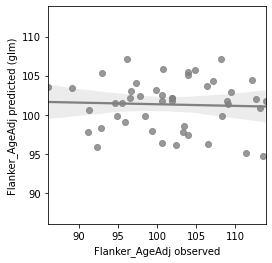

In [129]:
g = plot_predictions(behav_obs_pred)
g.set_title(condition)
plt.show()